In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [3]:
import copy
from collections import defaultdict, namedtuple
from datetime import datetime
import itertools
import os
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import tabulate
import wandb
from tqdm.notebook import tqdm

In [4]:
api = wandb.Api()

In [5]:
FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save_plot(save_path, bbox_inches='tight', should_print=False):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [6]:
Condition = namedtuple('Condition', ('relation', 'model_config', 'num_objects', 'dataset_size', 'dataset_power'))


def name_to_condition(name):
    relation, model_config, num_objects, dataset_size = name.split('-')[::2]
    num_objects = int(num_objects)
    dataset_size = int(dataset_size)
    return Condition(relation=relation, model_config=model_config, num_objects=num_objects, 
                     dataset_size=dataset_size, dataset_power=int(np.log2(dataset_size)))


In [7]:
CACHE_PATH = './results_cache.pickle'
BACKUP_CACHE_PATH = './results_cache_{date}.pickle'


def refresh_cache(new_values_dict=None, cache_path=CACHE_PATH):
    if new_values_dict is None:
        new_values_dict = {}
    
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as cache_file:
            cache = pickle.load(cache_file)
    
    else:
        cache = {}
    
    cache.update(new_values_dict)
    
    if os.path.exists(cache_path):
        os.rename(CACHE_PATH, BACKUP_CACHE_PATH.format(date=datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))

    with open(cache_path, 'wb') as cache_file:
        pickle.dump(cache, cache_file)

    return cache
 

cache = refresh_cache()

In [8]:
print(cache.keys())

dict_keys(['all_results', 'all_results_df', 'all_results_fixed_checkpoints', 'all_results_fixed_checkpoints_df'])


# Game plan
* Iterate through projects 
* Parse each project conditions from its name
* Aggregate each of the following statistics by model:
    * Peak accuracy
    * Epoch in which peak accuracy takes place
    * Epoch above some accuracy threshold
    * Did the model overfit (delta between train and val?)
* Start examining the effects of different manipulations:
    * Choice of relation
    * Number of objects
    * Size of the training set
    * Size of the model (in that one condition I ran larger)
* Probably more bar charts tables than anything else, unless we need learning curves



In [9]:
def get_model_name(run):
    return run.name.rsplit('-', 1)[0]


def get_run_seed(run):
    return int(run.name.rsplit('-', 1)[1])


def fix_project_configs(project):
    uri = f'{project.entity}/{project.name}'
    print(f'\tIn project {project.name}:')
    runs = api.runs(uri)
    configs_by_model = {}
    runs_to_fix = defaultdict(list)
    
#     for run in tqdm(runs, desc='Runs'):
    for run in runs:
        model_name = get_model_name(run)
        if run.config is None or len(run.config) == 0:
            runs_to_fix[model_name].append(run)

        elif model_name not in configs_by_model:
            configs_by_model[model_name] = copy.deepcopy(run.config)
    
    for model_name in runs_to_fix:
        if model_name not in configs_by_model:
            raise ValueError(f'In URI {uri}, could not find a config to fix model name {model_name}')
            
        sample_config = configs_by_model[model_name]
        
        for run in runs_to_fix[model_name]:
            config_copy = copy.deepcopy(sample_config)
            config_copy['seed'] = get_run_seed(run)
            config_copy['wandb_run_name'] = run.name
            run.config = config_copy
            run.update()
            print(f'\t\t{run.name}')
            
    return runs_to_fix


def print_missing_data(project, num_samples=50000):
    uri = f'{project.entity}/{project.name}'
    print(f'\tIn project {project.name}:')
    runs = api.runs(uri)
    configs_by_model = {}
    runs_to_fix = defaultdict(list)
    
#     for run in tqdm(runs, desc='Runs'):
    for run in runs:
        model_name = get_model_name(run)
        history_df = run.history(samples=num_samples)
        if 'num_objects_gen_test_acc' not in history_df:
            runs_to_fix[model_name].append(run)
            print(f'\t\t{run.name}')
            
    return runs_to_fix


def fix_all_projects(entity='simple-relational-reasoning-fixed-checkpoints', 
                     fix_func=fix_project_configs):
    projects = api.projects(entity)
    results = {}
    
    print(projects)
    for proj in tqdm([p for p in projects], desc='Projects'):
        condition = name_to_condition(proj.name)
#         print(proj.name)
#         print(condition)
        results[condition] = fix_func(proj)
        
    return results


In [10]:
fix_results = fix_all_projects(fix_func=print_missing_data)

<Projects simple-relational-reasoning-fixed-checkpoints>


	In project between-relation-larger-models-10-objects-65536-dataset:
	In project count-relation-larger-models-10-objects-65536-dataset:
	In project above-relation-larger-models-10-objects-65536-dataset:
	In project adjacent-relation-larger-models-10-objects-65536-dataset:
	In project between-relation-larger-models-5-objects-65536-dataset:
	In project count-relation-larger-models-5-objects-65536-dataset:
	In project above-relation-larger-models-5-objects-65536-dataset:
	In project adjacent-relation-larger-models-5-objects-65536-dataset:
	In project between-relation-default-models-10-objects-65536-dataset:


wandb: Network error resolved after 0:00:10.955797, resuming normal operation.


	In project count-relation-default-models-10-objects-65536-dataset:
	In project above-relation-default-models-10-objects-65536-dataset:
	In project adjacent-relation-default-models-10-objects-65536-dataset:
	In project between-relation-default-models-5-objects-65536-dataset:
	In project count-relation-default-models-5-objects-65536-dataset:


wandb: Network error resolved after 0:00:10.283592, resuming normal operation.


	In project above-relation-default-models-5-objects-65536-dataset:
	In project adjacent-relation-default-models-5-objects-65536-dataset:
	In project between-relation-default-models-10-objects-16384-dataset:
	In project count-relation-default-models-10-objects-16384-dataset:
	In project above-relation-default-models-10-objects-16384-dataset:
	In project adjacent-relation-default-models-10-objects-16384-dataset:
	In project between-relation-default-models-5-objects-16384-dataset:
	In project count-relation-default-models-5-objects-16384-dataset:
	In project above-relation-default-models-5-objects-16384-dataset:
	In project adjacent-relation-default-models-5-objects-16384-dataset:
	In project between-relation-default-models-10-objects-4096-dataset:
	In project count-relation-default-models-10-objects-4096-dataset:
	In project above-relation-default-models-10-objects-4096-dataset:


wandb: Network error resolved after 0:00:10.284828, resuming normal operation.


	In project adjacent-relation-default-models-10-objects-4096-dataset:
	In project between-relation-default-models-5-objects-4096-dataset:
	In project count-relation-default-models-5-objects-4096-dataset:
	In project above-relation-default-models-5-objects-4096-dataset:
	In project adjacent-relation-default-models-5-objects-4096-dataset:



In [11]:
fix_results = fix_all_projects()

<Projects simple-relational-reasoning-fixed-checkpoints>


	In project between-relation-larger-models-10-objects-65536-dataset:
	In project count-relation-larger-models-10-objects-65536-dataset:
	In project above-relation-larger-models-10-objects-65536-dataset:
	In project adjacent-relation-larger-models-10-objects-65536-dataset:
	In project between-relation-larger-models-5-objects-65536-dataset:
	In project count-relation-larger-models-5-objects-65536-dataset:
	In project above-relation-larger-models-5-objects-65536-dataset:
	In project adjacent-relation-larger-models-5-objects-65536-dataset:
	In project between-relation-default-models-10-objects-65536-dataset:
	In project count-relation-default-models-10-objects-65536-dataset:
	In project above-relation-default-models-10-objects-65536-dataset:
	In project adjacent-relation-default-models-10-objects-65536-dataset:
	In project between-relation-default-models-5-objects-65536-dataset:
	In project count-relation-default-models-5-objects-65536-dataset:
	In project above-relation-default-models-5-o

In [18]:
def parse_run(run, num_samples=50000, accuracy_threshold=0.95):
    history_df = run.history(samples=num_samples)
    run_results = {}
    
    max_accuracy_index = history_df.val_acc.idxmax()
    run_results['max_val_acc'] = history_df.val_acc[max_accuracy_index]
    run_results['max_val_acc_step'] = history_df.global_step[max_accuracy_index]
    
    accuracy_above_treshold_index = (history_df.val_acc >= accuracy_threshold).idxmax()
    if accuracy_above_treshold_index == 0:  # Never went above treshold
        run_results['acc_threshold_step'] = None
    else:
        run_results['acc_threshold_step'] = history_df.global_step[accuracy_above_treshold_index]
        
    run_results['acc_diff'] = history_df.train_acc.max() - history_df.val_acc.max()
    
    if 'num_objects_gen_test_acc' in history_df:
        run_results['num_objects_gen_test_acc'] = history_df.num_objects_gen_test_acc.max()
        run_results['num_objects_gen_test_acc_diff'] = run_results['max_val_acc'] - run_results['num_objects_gen_test_acc']
        
    else:
        print(f'Run {run.name} ({"/".join(run.path)}) has no generalization test accuracy')
    
    return run_results
    
    
def parse_project(project):
    uri = f'{project.entity}/{project.name}'
    runs = api.runs(uri)
    results_by_model = defaultdict(list)
    
    for run in tqdm(runs, desc='Runs'):
        try:
            seed_split_index = run.name.rindex('-')
            model_name = run.name[:seed_split_index]
            seed = int(run.name[seed_split_index + 1:])

            run_results = parse_run(run)
            run_results['seed'] = seed
            run_results['total_params'] = run.config['total_params']
            results_by_model[model_name].append(run_results)
            
        except Exception as e:
            print(e)
            print(run)
            print(run.name)
            print(run.config)
        
    return results_by_model
        
        
def parse_all_projects(entity='simple-relational-reasoning'):
    projects = api.projects(entity)
    results = {}
    
    print(projects)
    for proj in tqdm([p for p in projects], desc='Projects'):
        condition = name_to_condition(proj.name)
#         print(proj.name)
#         print(condition)
        results[condition] = parse_project(proj)
        
    return results


if 'all_results' not in cache:
    cache['all_results'] = parse_all_projects()
    cache = refresh_cache(cache)
    
all_results = cache['all_results']

In [19]:
if 'all_results_fixed_checkpoints' not in cache:
    cache['all_results_fixed_checkpoints'] = parse_all_projects(entity='simple-relational-reasoning-fixed-checkpoints')
    cache = refresh_cache(cache)
    
all_results_fixed_checkpoints = cache['all_results_fixed_checkpoints']

<Projects simple-relational-reasoning-fixed-checkpoints>


wandb: Network error resolved after 0:00:10.561299, resuming normal operation.


wandb: Network error resolved after 0:00:10.172836, resuming normal operation.


In [26]:
CONDITION_FIELDS = list(Condition._fields)
RUN_RESULTS_FIELDS = ['seed', 'total_params', 'max_val_acc', 'max_val_acc_step', 
                      'acc_threshold_step', 'acc_diff', 'num_objects_gen_test_acc', 
                      'num_objects_gen_test_acc_diff']
COLUMNS = CONDITION_FIELDS + ['model_name'] + RUN_RESULTS_FIELDS


def results_dict_to_df(results_dict):
    rows = []
    for condition, results_by_model in tqdm(results_dict.items(), desc='Condition'):
        condition_row_prefix = list(condition)
#         print(condition_row_prefix)
        for model_name, results_by_seed in tqdm(results_by_model.items(), desc='Result'):
            for run_results in results_by_seed:
                run_result_list = [run_results[field] for field in RUN_RESULTS_FIELDS]
                rows.append(condition_row_prefix + [model_name] + run_result_list)
                
    return pd.DataFrame(rows, columns=COLUMNS)


if 'all_results_df' not in cache:
    cache['all_results_df'] = results_dict_to_df(all_results)
    cache = refresh_cache(cache)
    
all_results_df = cache['all_results_df']

In [27]:
if 'all_results_fixed_checkpoints_df' not in cache:
    cache['all_results_fixed_checkpoints_df'] = results_dict_to_df(all_results_fixed_checkpoints)
    cache = refresh_cache(cache)
    
all_results_fixed_checkpoints_df = cache['all_results_fixed_checkpoints_df']

In [28]:
all_results_fixed_checkpoints_df.head()

,relation,model_config,num_objects,dataset_size,dataset_power,model_name,seed,total_params,max_val_acc,max_val_acc_step,acc_threshold_step,acc_diff,num_objects_gen_test_acc,num_objects_gen_test_acc_diff
0,between,larger,10,65536,16,cnn,108,34386,0.509460,1727,NaN,0.230774,0.500000,0.009460
1,between,larger,10,65536,16,cnn,107,34386,0.502686,383,NaN,0.224289,0.498840,0.003845
2,between,larger,10,65536,16,cnn,101,34386,0.506958,319,NaN,0.239685,0.504456,0.002502
3,between,larger,10,65536,16,cnn,100,34386,0.507141,2623,NaN,0.203308,0.495667,0.011475
4,between,larger,10,65536,16,cnn,109,34386,0.507385,2879,NaN,0.224091,0.499573,0.007812


# Plotting thoughts
* I want a single plotting function that will generate a group of bar charts
* Steps:
    1. Filter out particular parts of the dataframe.
    2. Group by one or more fields.
    3. Aggregate (mean, sd) the metric of choice.
    4. Group the bars by one of the group-by fields. 
* I probably want some way to specify formatting by the individual groups left (for example, a color for each model, a striping for each relation, ...)

**TODO:** 
* Pretitfy names
* Model (or other field orders)

In [74]:
DEFAULT_ORDERS = dict(
    model_name=['combined-object-mlp', 'cnn', 'relation-net', 'transformer'],
    relation=['adjacent', 'between', 'above', 'count']
)
DEFAULT_COLORMAP = plt.get_cmap('Dark2')
DEFAULT_BAR_KWARGS_BY_FIELD = defaultdict(lambda: defaultdict(dict))
DEFAULT_BAR_KWARGS_BY_FIELD['model_name'] = {name: dict(color=DEFAULT_COLORMAP(i))
                                             for i, name in enumerate(DEFAULT_ORDERS['model_name'])}
DEFAULT_BAR_KWARGS_BY_FIELD['num_objects'] = {5: {'hatch': ''}, 10: {'hatch': '/'}}

DEFAULT_BAR_KWARGS = dict(edgecolor='black')

SHADE_BAR_KWARGS = dict(alpha=0.25)

DEFAULT_TEXT_KWARGS = dict(fontsize=16)

DEFAULT_YLIM = (0, 1.05)

PRETTY_NAMES = {
    'cnn': 'CNN',
    'combined-object-mlp': 'MLP',
    'relation-net': 'RelationNet',
    'max_val_acc': 'Validation Accuracy',
    'model_config': 'Model Configuration Set',
    'num_objects_gen_test_acc': 'Generalization Test Accuracy'
}


def prettify(text):
    if isinstance(text, int) and text > 1000:
        return f'{text // 1000}k ($2^{{ {int(np.log2(text))} }}$)'
    
    text = str(text)
    
    if text in PRETTY_NAMES:
        return PRETTY_NAMES[text]

    return text.lower().replace('_', ' ').title()


def create_bar_chart(df, filter_dict, group_by_fields, metric,
                     orders=DEFAULT_ORDERS, sem=False, title=None,
                     bar_kwargs_by_field=DEFAULT_BAR_KWARGS_BY_FIELD,
                     bar_width=0.2, bar_spacing=0.5, default_bar_kwargs=DEFAULT_BAR_KWARGS,
                     text_kwargs=DEFAULT_TEXT_KWARGS, shade_metric=None, 
                     shade_bar_kwargs=SHADE_BAR_KWARGS, plot_shade_std=False,
                     add_chance_hline=True, ylim=DEFAULT_YLIM, legend_loc='best',
                     save_path=None, save_should_print=False):
    orders = copy.deepcopy(orders)
    major_group_by = group_by_fields[0]
    minor_group_by = group_by_fields[1:]
    
    if default_bar_kwargs is None:
        default_bar_kwargs = dict()
    
    if shade_bar_kwargs is None:
        shade_bar_kwargs = dict()
    
    shade_bar_kwargs_temp = copy.deepcopy(default_bar_kwargs)
    shade_bar_kwargs_temp.update(shade_bar_kwargs)
    shade_bar_kwargs = shade_bar_kwargs_temp
    
    filtered_df = df.copy(deep=True)
    
    if filter_dict is not None:
        for filter_name, filter_value in filter_dict.items():
            if isinstance(filter_value, (list, tuple)):
                filtered_df = filtered_df[filtered_df[filter_name].isin(filter_value)]
                if filter_name in orders:
                    orders[filter_name] = list(filter(lambda v: v in filter_value, orders[filter_name]))
            else:
                filtered_df = filtered_df[filtered_df[filter_name].eq(filter_value)]
            
    grouped_df = filtered_df.groupby(group_by_fields)
    mean = grouped_df[metric].mean()
    std = grouped_df[metric].std()    
    if sem:
        std /= np.sqrt(grouped_df[metric].count())
        
    if shade_metric is not None:
        shade_mean = grouped_df[shade_metric].mean()
        shade_std = grouped_df[shade_metric].std()    
        if sem:
            shade_std /= np.sqrt(grouped_df[shade_metric].count())

    if major_group_by in orders:
        major_group_values = orders[major_group_by]
    else:
        major_group_values = mean.index.unique(level=major_group_by)
        
    minor_group_values_list = []
    
    for minor_field_name in minor_group_by:
        if minor_field_name in orders:
            minor_group_values_list.append(orders[minor_field_name])
        else:
            minor_group_values_list.append(mean.index.unique(level=minor_field_name))
    
    major_kwargs = bar_kwargs_by_field[major_group_by]
    minor_kwargs_list = [bar_kwargs_by_field[minor_field_name] for minor_field_name in minor_group_by]
    
    figure = plt.figure(figsize=(8, 6))
    x = 0
    
    for major_level_value in major_group_values:
        major_level_kwargs = major_kwargs[major_level_value]
        
        for minor_level_value_combination in itertools.product(*minor_group_values_list):
            combined_minor_kwargs = {}
            for i, value in enumerate(minor_level_value_combination):\
                combined_minor_kwargs.update(minor_kwargs_list[i][value])
                
            major_and_minor_key = (major_level_value, *minor_level_value_combination)
            
            if shade_metric:  # intentionally shade before the real bars
                shade_m = shade_mean.loc[major_and_minor_key]
                if plot_shade_std:
                    shade_s = shade_std.loc[major_and_minor_key]
                else:
                    shade_s = 0
                plt.bar(x, shade_m, yerr=shade_s, width=bar_width, **major_level_kwargs, 
                        **combined_minor_kwargs, **shade_bar_kwargs)
            
            m = mean.loc[major_and_minor_key]
            s = std.loc[major_and_minor_key]
            plt.bar(x, m, yerr=s, width=bar_width, **major_level_kwargs, 
                    **combined_minor_kwargs, **default_bar_kwargs)
            
            
            
            x += bar_width
        
        x += bar_spacing
        
    minor_group_length = np.product([len(values) for values in minor_group_values_list])
    x_tick_locations = np.arange(len(major_group_values)) * (bar_spacing + bar_width * minor_group_length) +\
                        bar_width * (minor_group_length / 2 - 0.5)
    plt.xticks(x_tick_locations, [prettify(val) for val in major_group_values], **text_kwargs)
    plt.gca().tick_params(axis='both', which='major', labelsize=12)
    
    if add_chance_hline:
        xlim = plt.xlim()
        plt.hlines(0.5, *xlim, linestyle='--', alpha=0.5)
        plt.xlim(*xlim)
        
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel(prettify(major_group_by), **text_kwargs)
    plt.ylabel(prettify(metric), **text_kwargs)
    plt.title(title, fontsize=20)
    
    patches = []
    ncol = 0
    for kwarg_set, field_name in zip([major_kwargs] + minor_kwargs_list, group_by_fields):
        if any([len(val) > 0 for val in kwarg_set.values()]):
            ncol += 1
            for field_value in kwarg_set:
                if field_name in filter_dict and field_value not in filter_dict[field_name]:
                    continue
                
                patch_kwargs = dict(facecolor='none', edgecolor='black')
                patch_kwargs.update(kwarg_set[field_value])
                patches.append(matplotlib.patches.Patch(**patch_kwargs, label=prettify(field_value)))
    
    if len(patches) > 0: 
        plt.legend(handles=patches, loc=legend_loc, ncol=ncol, fontsize=12)
    
    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)
    
    plt.show()
    

/Users/guydavidson/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.


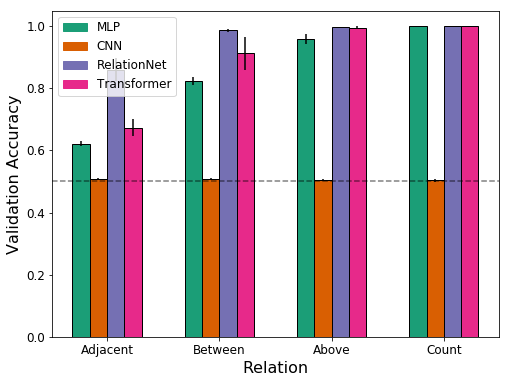

In [81]:
create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(model_config='default', num_objects=5, dataset_power=14), 
                 group_by_fields=('relation', 'model_name'),
                 metric='max_val_acc',
                 save_path='default_5_16k_group_by_relation.pdf',
#                  title='Default settings (5 objects, 16k examples) by relation and model size'
                )


/Users/guydavidson/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.


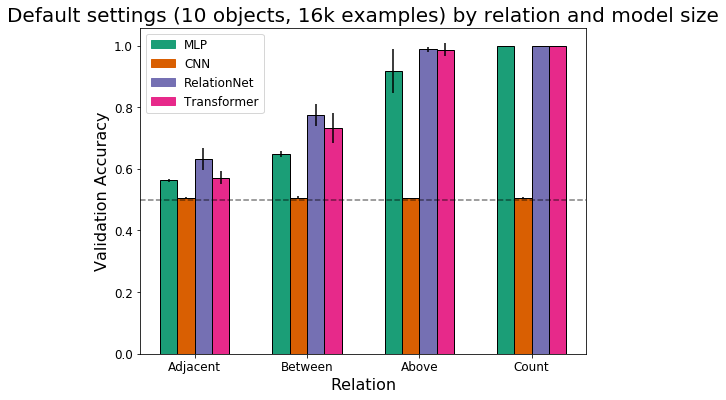

In [56]:
create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(model_config='default', num_objects=10, dataset_power=14), 
                 group_by_fields=('relation', 'model_name'),
                 metric='max_val_acc',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Default settings (10 objects, 16k examples) by relation and model size')


/Users/guydavidson/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.


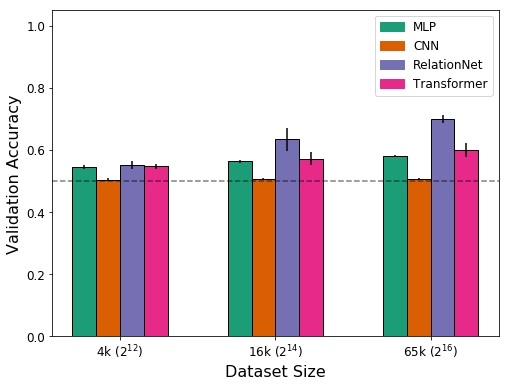

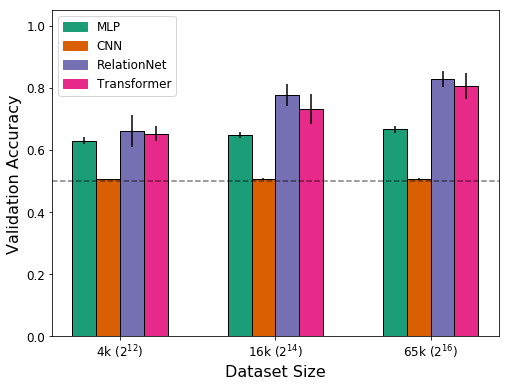

In [82]:
df = create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(model_config='default', num_objects=10, relation='adjacent'), 
                 group_by_fields=('dataset_size', 'model_name'),
                 metric='max_val_acc',
#                  save_path='default_5_adjacent_group_by_dataset_size.pdf',
#                  title='Dataset size effect, adjacent relation'
                     )


create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(model_config='default', num_objects=10, relation='between'), 
                 group_by_fields=('dataset_size', 'model_name'),
                 metric='max_val_acc',
                 save_path='default_10_between_group_by_dataset_size.pdf',
#                  title='Dataset size effect, between relation'
                )


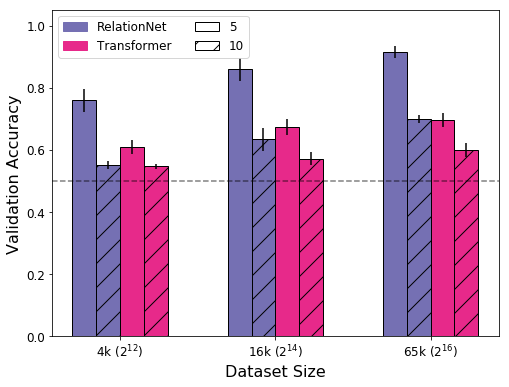

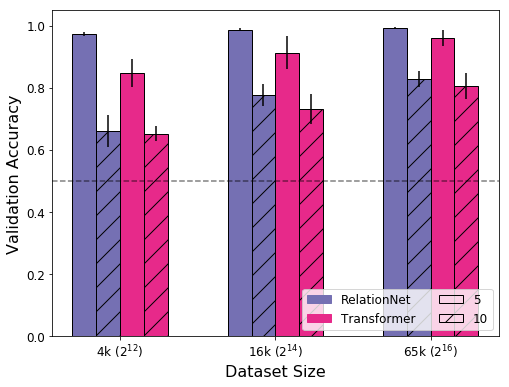

In [76]:
create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(model_config='default', relation='adjacent',
                                  model_name=['relation-net', 'transformer']), 
                 group_by_fields=['dataset_size', 'model_name', 'num_objects'],
                 metric='max_val_acc', legend_loc='upper left',
                 save_path='default_adjacent_group_by_dataset_size_and_num_objects.pdf'
                )


create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(model_config='default', relation='between',
                                  model_name=['relation-net', 'transformer']), 
                 group_by_fields=['dataset_size', 'model_name', 'num_objects'],
                 metric='max_val_acc', legend_loc='lower right',
                 save_path='default_between_group_by_dataset_size_and_num_objects.pdf'
                )



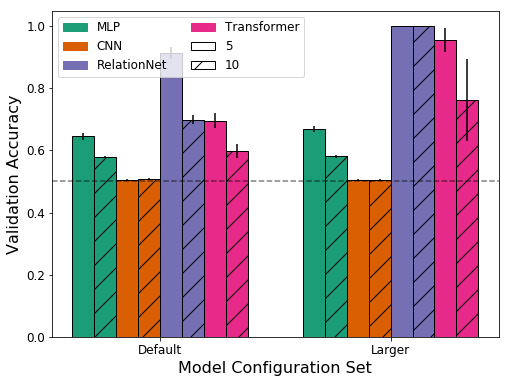

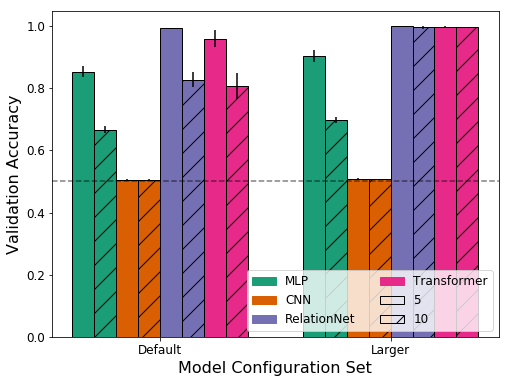

In [84]:
create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(relation='adjacent', dataset_power=16,
#                                   model_name=['relation-net', 'transformer']
                                 ), 
                 group_by_fields=['model_config', 'model_name', 'num_objects'],
                 metric='max_val_acc',
                 save_path='adjacent_group_by_model_config_and_num_objects.pdf'
                )


create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(relation='between', dataset_power=16,
#                                   model_name=['relation-net', 'transformer']
                                 ), 
                 group_by_fields=['model_config', 'model_name', 'num_objects'],
                 metric='max_val_acc', legend_loc='lower right',
                 save_path='between_group_by_model_config_and_num_objects.pdf'
                )



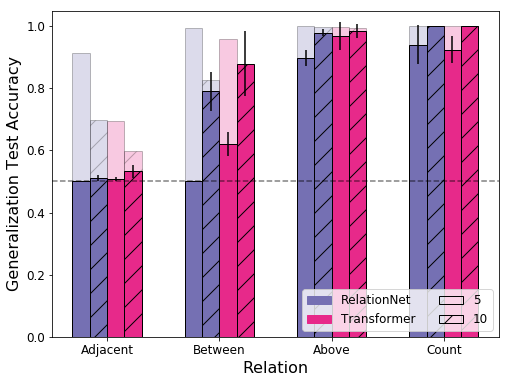

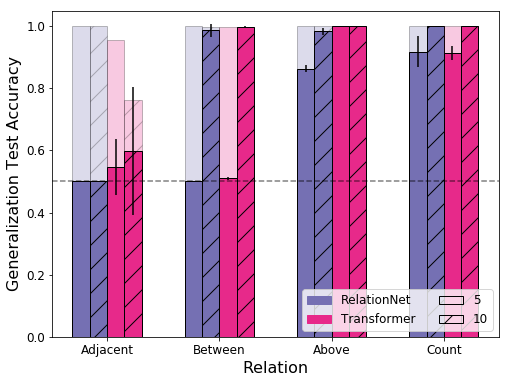

In [79]:
create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(model_config='default', # relation=['adjacent', 'between'],
                                  dataset_power=16, model_name=['relation-net', 'transformer']
                                 ), 
                 group_by_fields=['relation', 'model_name', 'num_objects'],
                 metric='num_objects_gen_test_acc', shade_metric='max_val_acc', legend_loc='lower right',
                 save_path='generalization_test_default_models.pdf'
                )


create_bar_chart(all_results_fixed_checkpoints_df, 
                 filter_dict=dict(model_config='larger', # relation=['adjacent', 'between'],
                                  dataset_power=16, model_name=['relation-net', 'transformer']
                                 ), 
                 group_by_fields=['relation', 'model_name', 'num_objects'],
                 metric='num_objects_gen_test_acc', shade_metric='max_val_acc', legend_loc='lower right',
                 save_path='generalization_test_larger_models.pdf'
                )


# Make a big 'ol table

In [ ]:
table_group_by_columns = ['model_config', 'num_objects', 'dataset_size', 'relation', 'model_name']
custom_sorted_res = all_results_df.copy()
custom_sorted_res['model_name'] = pd.Categorical(custom_sorted_res['model_name'], 
                                                 ['combined-object-mlp', 'cnn', 'relation-net', 'transformer'])
custom_sorted_res['relation'] = pd.Categorical(custom_sorted_res['relation'], 
                                                 ['adjacent', 'above', 'count'])

custom_sorted_res = custom_sorted_res.sort_values('model_name').sort_values('relation')

grouped = custom_sorted_res.groupby(table_group_by_columns, as_index=False)
mean = grouped.mean()
mean.to_latex('./figures/result_table.txt', 
              columns=table_group_by_columns + ['max_val_acc', 'acc_diff'],
              float_format='%.3f', index=False, bold_rows=True)

In [ ]:
all_results_df.head()

In [ ]:
all_results_df[all_results_df.model_name != 'cnn'].acc_diff.max()

In [ ]:
all_results_df.acc_diff.max()

In [ ]:
all_results_df[all_results_df.model_name == 'cnn'].acc_diff.max()

In [ ]:
r = all_results_df[all_results_df.model_config == 'larger']
r.head()
# r = r[r.model_name.is != 'cnn']
# r = r[r.model_name != 'combined-object-mlp']
# r.loc[r.max_val_acc.idxmin()]

In [ ]:
r.num_objects.unique()

In [ ]:
r.dataset_size.unique()

In [ ]:
r.relation.unique()

In [ ]:
all_results_df.groupby(['model_config', 'model_name']).total_params.mean()

In [88]:
all_results_fixed_checkpoints_df[all_results_fixed_checkpoints_df.model_config != 'default']

,relation,model_config,num_objects,dataset_size,dataset_power,model_name,seed,total_params,max_val_acc,max_val_acc_step,acc_threshold_step,acc_diff,num_objects_gen_test_acc,num_objects_gen_test_acc_diff
0,between,larger,10,65536,16,cnn,108,34386,0.509460,1727,NaN,0.230774,0.500000,0.009460
1,between,larger,10,65536,16,cnn,107,34386,0.502686,383,NaN,0.224289,0.498840,0.003845
2,between,larger,10,65536,16,cnn,101,34386,0.506958,319,NaN,0.239685,0.504456,0.002502
3,between,larger,10,65536,16,cnn,100,34386,0.507141,2623,NaN,0.203308,0.495667,0.011475
4,between,larger,10,65536,16,cnn,109,34386,0.507385,2879,NaN,0.224091,0.499573,0.007812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,adjacent,larger,5,65536,16,combined-object-mlp,107,3842,0.675293,49855,NaN,0.010513,0.514038,0.161255
316,adjacent,larger,5,65536,16,combined-object-mlp,102,3842,0.653870,25023,NaN,0.025574,0.515259,0.138611
317,adjacent,larger,5,65536,16,combined-object-mlp,103,3842,0.673767,35519,NaN,0.011734,0.519104,0.154663
318,adjacent,larger,5,65536,16,combined-object-mlp,105,3842,0.676880,36351,NaN,0.025085,0.516968,0.159912


In [85]:
4 * 2 * 3 * 4 * 10

960

In [87]:
4 * 2 * 4 * 10

320

In [ ]:
partial_df.groupby('model_name').mean()

In [ ]:
for relation in ('adjacent', 'above', 'count'):
    d = partial_df[partial_df['relation'] == relation]
    print(d.head())
    print(d.groupby('model_name').max_val_acc.mean())

In [ ]:
partial_df.groupby(['relation', 'model_name']).mean()

In [ ]:
'hello world'.title()

In [ ]:
partial_df.head()

In [ ]:
partial_df.tail()

In [ ]:
d = all_results_df.copy()

In [ ]:
e = d[d['relation'].eq('adjacent')]

In [ ]:
d.shape, e.shape

In [ ]:
g = e.groupby(['num_objects', 'model_name'])

In [ ]:
np.sqrt(g['relation'].count())

In [ ]:
r = g.max_val_acc.mean()

In [ ]:
r.index.unique()

In [ ]:
r.loc[(5, 'cnn')]

In [ ]:
r.index.get_level_values('num_objects')

In [ ]:
history_df = r.history(samples=10000)

In [ ]:
history_df.columns

In [ ]:
history_df.val_acc.idxmax()

In [ ]:
history_df.iloc[3545]

In [ ]:
history_df.iloc[:25]

In [ ]:
2 => 1
5 => 2
8 => 3

In [ ]:
h2 = runs[28].history()
h2[:20]

In [ ]:
h2.val_acc.isnull().sum()

In [ ]:
history_df.val_acc[:501].isnull().sum()

In [ ]:
(h2.val_acc > 0.8).idxmax()

In [ ]:
h2.train_acc.max() - h2.val_acc.max()

In [ ]:
run = api.run('simple-relational-reasoning-fixed-checkpoints/count-relation-default-models-5-objects-4096-dataset/o6p5tg8f')

In [ ]:
parse_run(run)

In [ ]:
files = run.files()

In [ ]:
[f for f in files]

In [ ]:
f = files[0]

In [ ]:
f = list(filter(lambda f: f.name.endswith('.ckpt'), files))[0]

In [ ]:
f.download?

In [ ]:
f.name

In [ ]:
h = run.history()

In [ ]:
'val_acc' in h

In [ ]:
files = valid_run.files()

In [ ]:
f = list(files)[2]

In [ ]:
int([x for x in f.name.split('-') if x.startswith('epoch')][0].split('=')[1])

In [ ]:
import numpy as np

In [ ]:
np.argmax([1, 2, 0])